In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import plotly.express as px
import os
import numpy as np

In [21]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [22]:
os.listdir('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-bogdanova//shared/homeworks/python_ds_miniprojects/6')

['ads_data.csv', 'ads_clients_data.csv']

In [23]:
# Import DF
ads_data             = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-bogdanova//shared/homeworks/python_ds_miniprojects/6/ads_data.csv')
ads_clients_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-bogdanova//shared/homeworks/python_ds_miniprojects/6/ads_clients_data.csv')

In [24]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [25]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [26]:
# formating date
ads_data.date              = pd.to_datetime(ads_data.date)
ads_data.time             = pd.to_datetime(ads_data.time)

ads_clients_data.date            = pd.to_datetime(ads_clients_data.date)
ads_clients_data.create_date = pd.to_datetime(ads_clients_data.create_date)

In [27]:
# Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. 
# Тонкий момент: помните, что некоторые показываемые объявления не кликались, 
# и при группировке в таких случаях не будет строк с кликами,
# а для подсчёта среднего по объявлениям их нужно учитывать. 
# Округлите ответы до целых чисел.
view_event_to_ad = ads_data \
    .query('event == "view"') \
    .groupby('ad_id', as_index = False) \
    .agg({'date' : 'count'}) \
    .rename(columns = {'date' : 'view_count'})
click_event_to_ad = ads_data \
    .query('event == "click"') \
    .groupby('ad_id', as_index = False) \
    .agg({'date' : 'count'}) \
    .rename(columns = {'date' : 'click_count'})
all_event_to_ad =view_event_to_ad \
    .merge(click_event_to_ad, how = 'left', on = 'ad_id') \
    .fillna(0)
all_event_to_ad

,ad_id,view_count,click_count
0,2,101,1.0
1,3,184,3.0
2,1902,41,1.0
3,2064,35,0.0
4,2132,58,1.0
...,...,...,...
951,122004,100,4.0
952,122013,156,0.0
953,122023,68,0.0
954,122031,138,1.0


In [28]:
# Average view
mean_view = all_event_to_ad.view_count.mean().round(decimals=0)
mean_view

932.0

In [29]:
# Average_click
mean_click = all_event_to_ad.click_count.mean().round(decimals=0)
mean_click


114.0

In [30]:
# Прологарифмируйте число показов, 
# а затем постройте такой график, чтобы можно было понять форму распределения. 

all_event_to_ad['log_view_count'] = np.log(all_event_to_ad.view_count)
# all_event_to_ad.log_view_count = all_event_to_ad.log_view_count.str.replace('-inf', '0')
# all_event_to_ad
all_event_to_ad

,ad_id,view_count,click_count,log_view_count
0,2,101,1.0,4.615121
1,3,184,3.0,5.214936
2,1902,41,1.0,3.713572
3,2064,35,0.0,3.555348
4,2132,58,1.0,4.060443
...,...,...,...,...
951,122004,100,4.0,4.605170
952,122013,156,0.0,5.049856
953,122023,68,0.0,4.219508
954,122031,138,1.0,4.927254


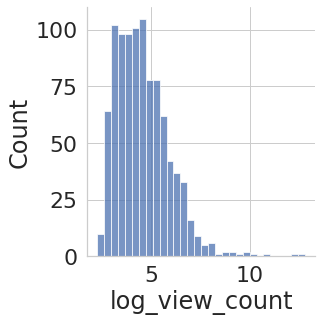

In [31]:
sns.displot(all_event_to_ad['log_view_count'])

In [32]:
# Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). 

average_view_by_day = ads_data \
    .query('event == "view"') \
    .groupby(['ad_id', 'date'], as_index = False) \
    .agg({'platform': 'count'}) \
    .rename(columns = {'platform' : 'view_day_count'}) \
    .groupby('date') \
    .agg({'view_day_count': 'mean'}) \
    .rename(columns = {'ad_id': 'mean_view'}) \
    .round(decimals = 0)
average_view_by_day

,view_day_count
date,
2019-04-01,154.0
2019-04-02,138.0
2019-04-03,164.0
2019-04-04,676.0
2019-04-05,919.0
2019-04-06,277.0


In [33]:
# После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

sma_average_view_by_day = average_view_by_day \
    .rolling(2).mean() \
    .round(decimals = 0) \
    .reset_index() \
    .rename(columns = {'view_day_count' : 'sma_aver'})
sma_average_view_by_day

,date,sma_aver
0,2019-04-01,NaN
1,2019-04-02,146.0
2,2019-04-03,151.0
3,2019-04-04,420.0
4,2019-04-05,798.0
5,2019-04-06,598.0


In [34]:
# Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? 
# Округлите ответ до целого числа.

fig = px.line(sma_average_view_by_day, x="date", y="sma_aver")
fig.show()

In [35]:
# Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?

common_aver_view = average_view_by_day \
    .reset_index() \
    .rename(columns ={'view_day_count' : 'common_aver'})
merge = common_aver_view \
    .merge(sma_average_view_by_day, on = 'date')
merge['modul'] = abs(merge.common_aver - merge.sma_aver)
merge

,date,common_aver,sma_aver,modul
0,2019-04-01,154.0,NaN,NaN
1,2019-04-02,138.0,146.0,8.0
2,2019-04-03,164.0,151.0,13.0
3,2019-04-04,676.0,420.0,256.0
4,2019-04-05,919.0,798.0,121.0
5,2019-04-06,277.0,598.0,321.0


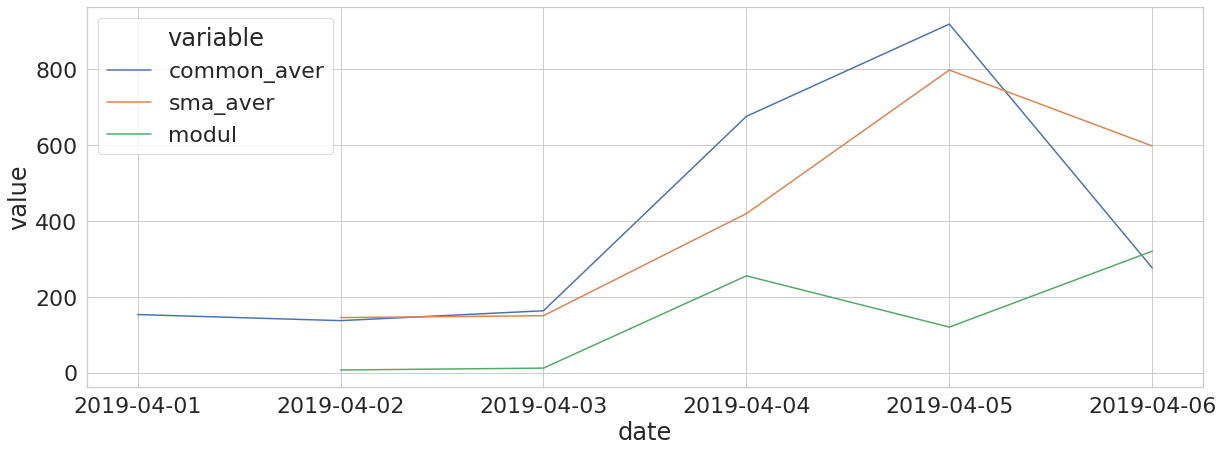

In [36]:
# Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего 
for_plot = merge. melt('date')
sns.lineplot(data = for_plot, x = 'date', y = 'value', hue = 'variable')

In [37]:
# Объедините данные рекламы с данными о рекламных клиентах и 
# найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).
# В качестве ответа укажите среднее число дней.
merge_init_data = ads_data \
    .merge(ads_clients_data, on = 'client_union_id')

# ищем разницу во времени для всех событий
merge_init_data['date_diff'] =  merge_init_data['date_x'] - merge_init_data['create_date']

# группируем по рекламному кабинету и находим min разницу
min_diff = merge_init_data \
    .groupby('client_union_id', as_index = False) \
    .agg({'date_diff' : 'min'})

min_diff.date_diff.mean()

Timedelta('124 days 09:04:43.532219570')

In [72]:
# Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.
merge_init_data

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,date_diff
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-04,2019-04-04 18:07:25,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999996,2019-04-04,2019-04-04 18:29:06,view,ios,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999997,2019-04-04,2019-04-04 18:55:46,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days
999998,2019-04-04,2019-04-04 19:21:09,view,android,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04,31 days


In [38]:
# Общее число клиентов
all_clients = ads_clients_data.client_union_id.nunique()

In [39]:
# Количество клиентов запустивших первую рекламу в течение не более 365 дней от создания рекламного кабинета
#  Ищем минимальную разницу
min_diff = merge_init_data \
    .groupby('client_union_id', as_index = False) \
    .agg({'date_diff' : 'min'}) \
    .sort_values('date_diff')

# Кол-во клиентов сделавших рекламу:
clients_make_ad = min_diff.client_union_id.nunique()

# Общее число клиентов
all_clients = ads_clients_data.client_union_id.nunique()

# Среднее в %
round(clients_make_ad/all_clients*100, 2)

0.69

In [45]:
# Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). 
# Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365].

# В качестве основы расчета берем переменную min_diff и добавим в нее категориальную колонку на основе колонки date_diff

bins = [pd.Timedelta(days = 0), pd.Timedelta(days= 30),  pd.Timedelta(days= 90), pd.Timedelta(days= 180), pd.Timedelta(days= 365)]
min_diff['date_diff_categorical'] = pd.cut(min_diff.date_diff, bins = bins, labels = ['less than 30 days', '30-90 days', '90-180 days', 'more than 180 days'])

# Определим количество уникальных клиентов по категоиям
unique_clients = min_diff \
    .groupby('date_diff_categorical', as_index = False) \
    .agg({'client_union_id' : 'nunique'}) \
    .rename(columns = {'client_union_id' : 'nunique'})

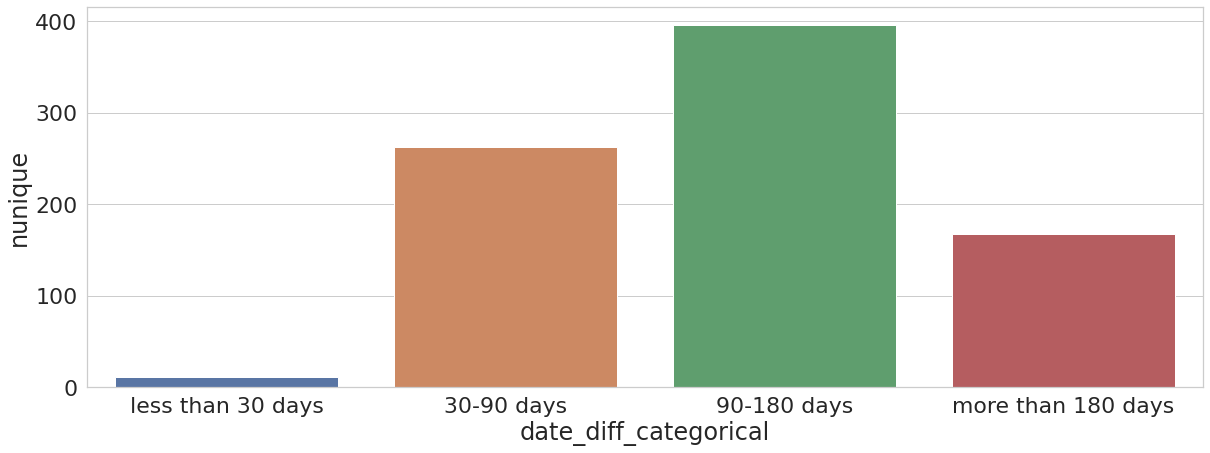

In [46]:
# Строим барплот
sns.barplot(data=unique_clients,  x='date_diff_categorical', y='nunique')